In [13]:
library(rgdal)
library(broom)
library(leaflet)
library(htmltools)
library(ggplot2)
library(dplyr)
library(sf)
library(raster)
library(spData)
library(treemap)
library(mapview)
library(RColorBrewer)

In [14]:
#download shapefile from https://data.cityofevanston.org/Information-Technology-includes-maps-geospatial-da/Trees/utcj-vfdh

#read shapefile data from working directory (geo_export_e8bbf4c5-0fec-44f8-bef7-e6204a3a59c2.shp)
shape <- readOGR(".", "geo_export_2e3d9ff8-36e0-48e4-aebe-1433cac65330")
#convert to data frame
shape <- fortify(as.data.frame(shape), region="id")

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\Jordan\Desktop\evanston_viz_2019\src\scripts", layer: "geo_export_2e3d9ff8-36e0-48e4-aebe-1433cac65330"
with 34385 features
It has 34 fields


In [3]:
#remove rows from shape dataframe where species value is a vacant lot or stump
shape <- shape %>% filter(!grepl('Vacant|stump', spp))

#add column to shape dataframe for tree genus
shape$genus <- sub(" .*", "", shape$spp)

In [11]:
#generate genus palette 
#genus.pal <-  colorFactor(c(distinctColorPalette(length(unique(shape$genus)))), domain = shape$genus)
#generate interactive leaflet map showing tree coords as circles colored by genus
#with popup labels showing species
m <- (leaflet(shape) %>%
  addProviderTiles(providers$CartoDB.PositronNoLabels) %>% 
  setView(lng = -87.67, lat = 42.051, zoom = 17) %>%
  #setView(lng = -87.655, lat = 42.04, zoom = 14) %>%
  addCircleMarkers(~jitter(coords.x1, factor=10), ~jitter(coords.x2, factor=10),
                   radius = shape$dbh/2,
                   color = c("#78C679"),
                   stroke = TRUE, opacity = 0.5, weight = 0.8, 
                   label = ~as.character(dbh))) #%>%
  #addLegend(pal = genus.pal, values = shape$genus,
            #title = "Tree genera")
m

HTML widgets cannot be represented in plain text (need html)

In [30]:
mapshot(m, file = "city_of_trees_higher_res.png", vheight=1944, zoom=2)

In [25]:
#Filter shape data frame by species of Elm ('Ulmus')
Elm.species <- shape %>% filter(grepl('Ulmus', spp))

#create color function ramping from red to green
colfunc <- colorRampPalette(c("green", "red"))

#make list of conditions
conditions <- c("Excellent", "Very Good", "Good", "Fair", "Poor", "Critical", "Dead", "N/A")

#generate color palette using color function for categories, set "NA" to gray
pal <- colorFactor(c(colfunc(7), "gray"), domain = conditions , ordered = TRUE, levels = conditions)

#import raster data
raster_filepath <- "./LC08_CU_021007_20160912_20181201_C01_V01_ST.tif"
r <- raster(raster_filepath)

#aggregate raster data to decrease file size 
r <- aggregate(r)

#generate color palette for raster data 
temp.pal <- colorNumeric(c("#31A354", "#ADDD8E", "#ff1d00"), values(r),
                    na.color = "transparent")

Warning message in pal(condition):
"Some values were outside the color scale and will be treated as NA"Warning message in pal(condition):
"Some values were outside the color scale and will be treated as NA"Warning message in pal(v):
"Some values were outside the color scale and will be treated as NA"

HTML widgets cannot be represented in plain text (need html)
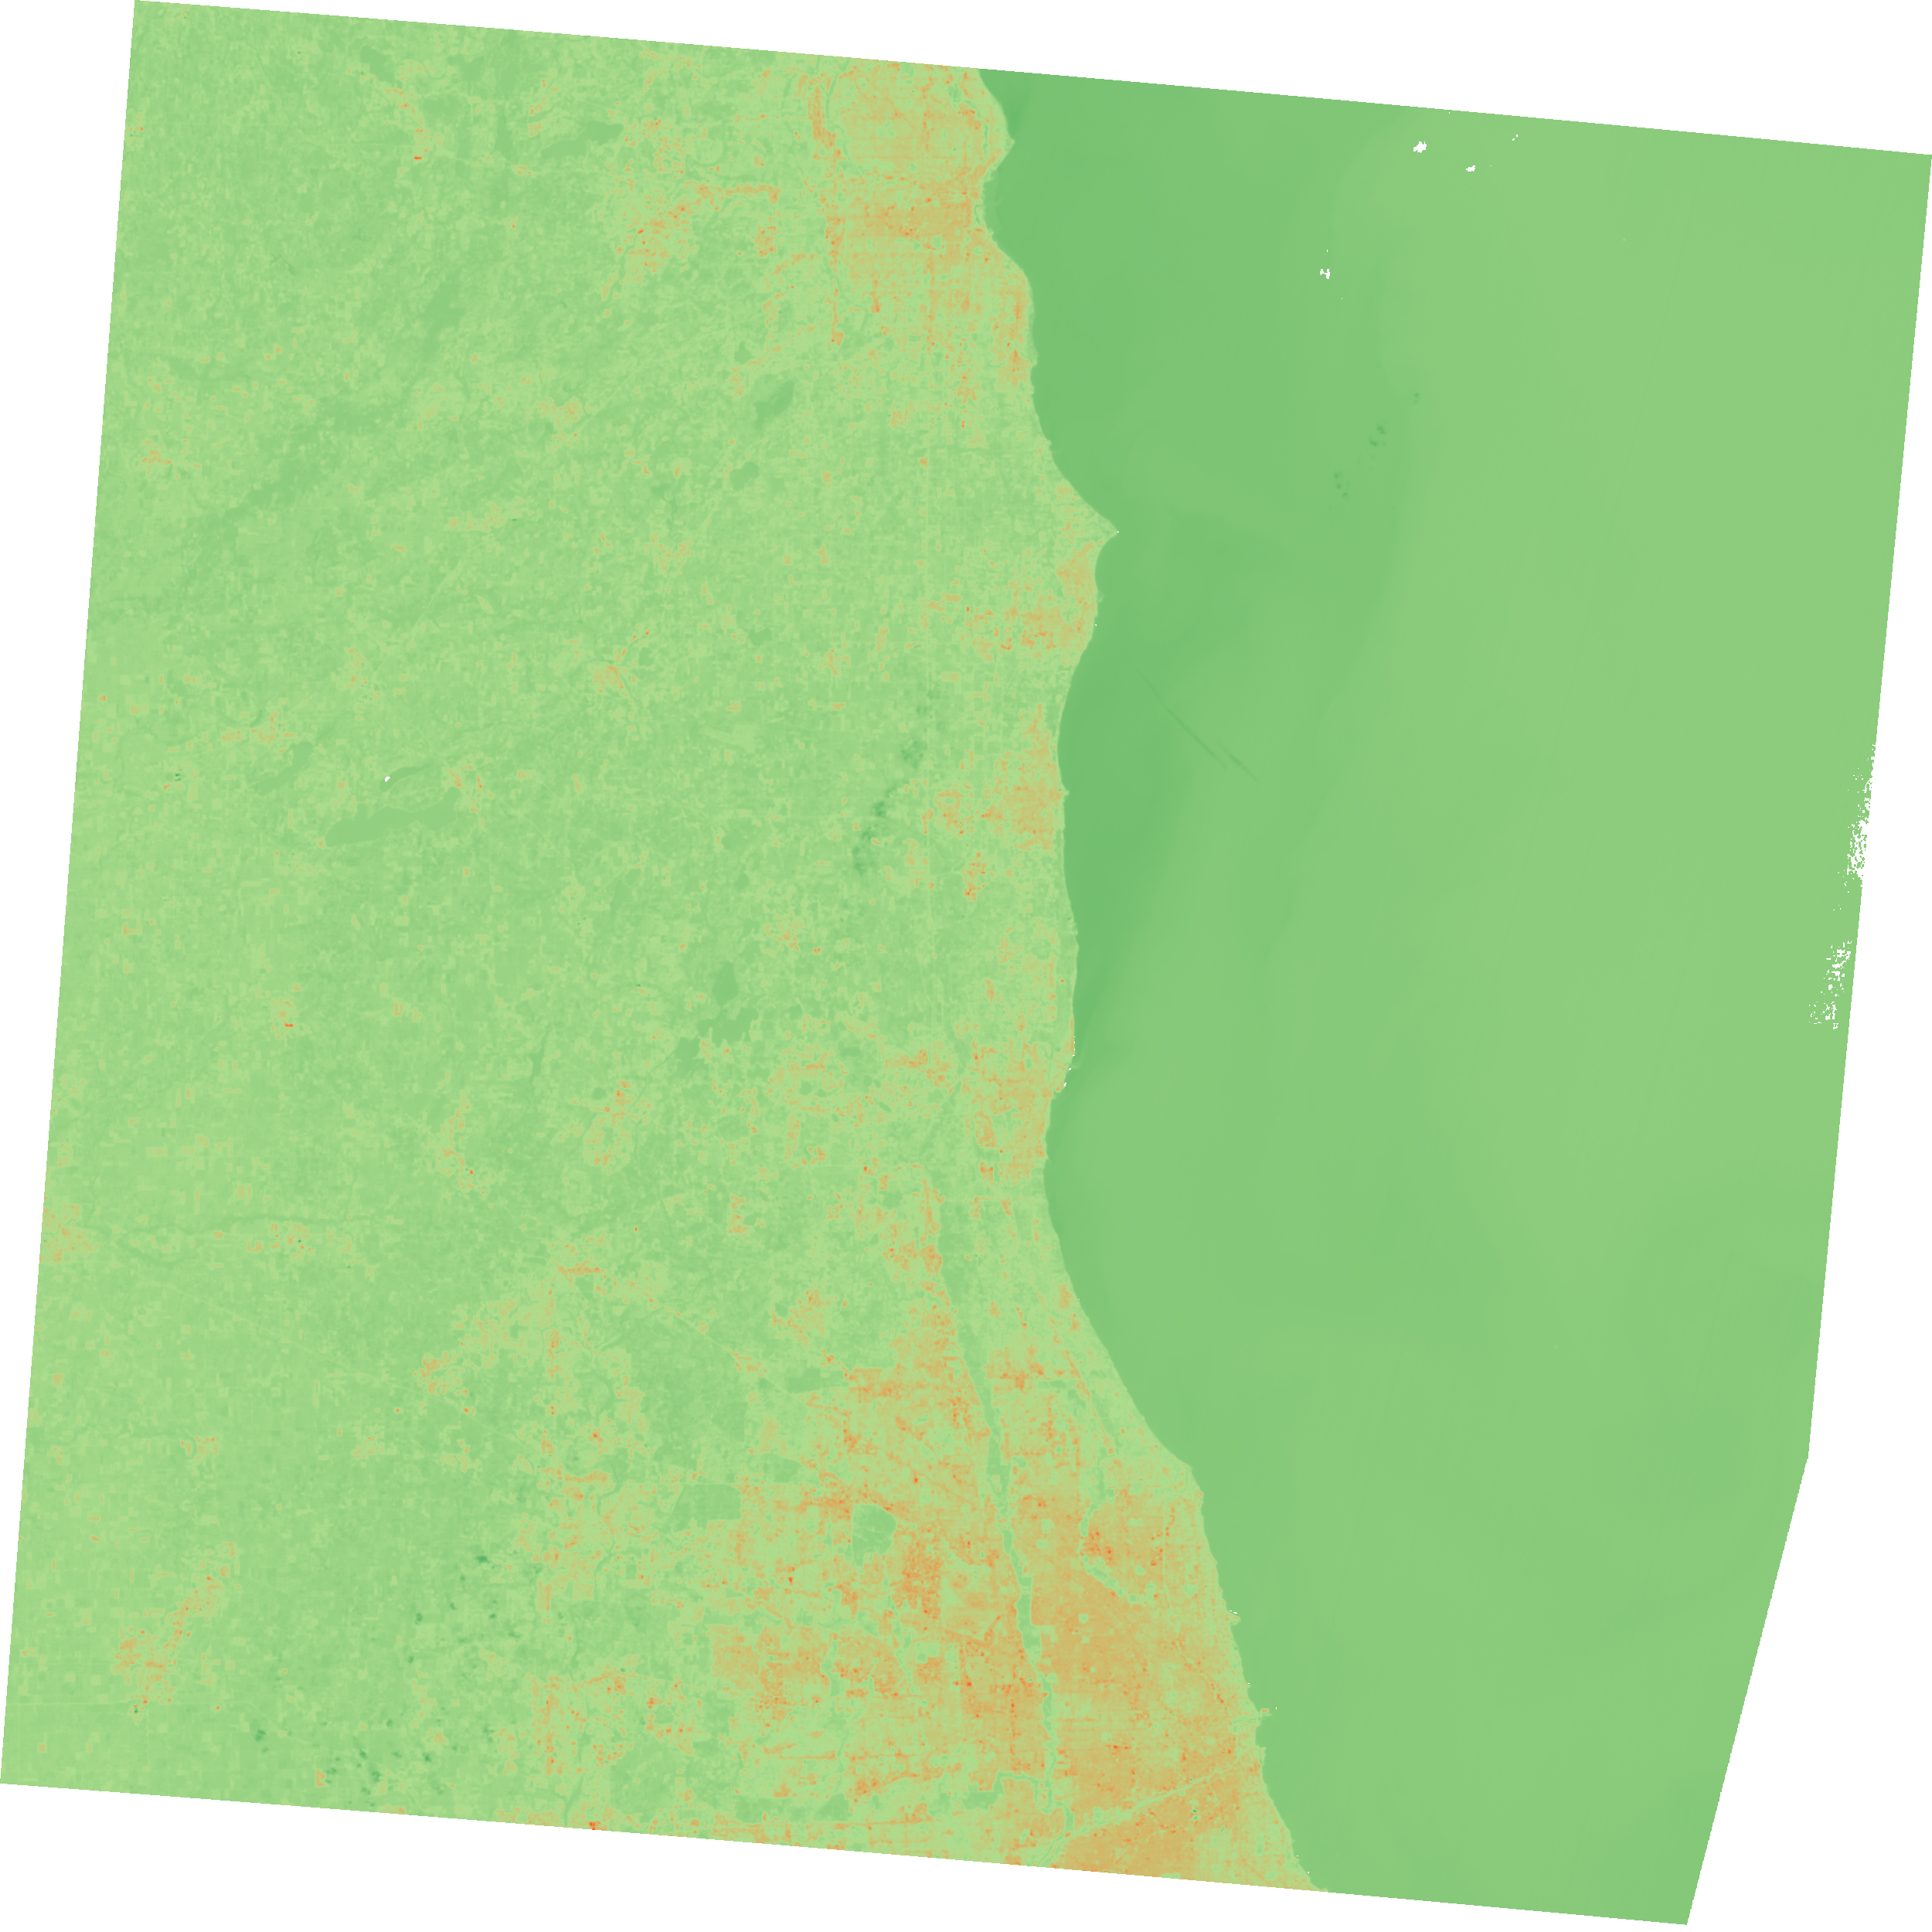

In [46]:
#plot only points for elm trees colored by condition with popup labels showing condition and species name
#on top of surface temp raster data with legends for each, tried to reorder Elm tree legend but it's being a turd
#zoomed in on Evanston area 
conversion = (values(r)-2360)/7 #for K surface temp to ambient temp Celsius
palette <- colorFactor(c(colfunc(7), "gray"), domain = conditions , ordered = TRUE, levels = conditions)
temp.pal <- colorNumeric(c("#31A354", "#ADDD8E", "#ff1d00"), conversion,
                    na.color = "transparent")
e <- (
  leaflet(Elm.species) %>%  setView(lng = -87.695, lat = 42.045, zoom = 14) %>%
  addProviderTiles(providers$CartoDB.PositronNoLabels) %>%
  addRasterImage(
      (r-2360)/7, 
      maxBytes = 5 * 1024 * 1024, 
      colors = temp.pal, opacity = 0.5) %>%
  addLegend(pal = temp.pal, values = conversion,
            title = "Surface temp") %>%
  addCircleMarkers(
      ~jitter(coords.x1, factor=10), 
      ~jitter(coords.x2, factor=10),
      radius = shape$dbh/8,
      color = ~pal(condition),
      stroke = TRUE, opacity = 0.5, weight = 0.8,
      label = ~htmlEscape(paste0(spp, '.', condition))) %>%
  addLegend(
      pal = palette, 
      values = Elm.species$condition,
      title = "Elm Tree<br> Conditions")
)
e

In [47]:
mapshot(e, file = "ulmus_condition.png", vheight=900, vwi zoom=2)

In [31]:
#create treemap
#summarize genus data from shape dataframe
treemap.data <- read.csv(file="../data/interim/Common_canopy.csv")

#Evanston treemap 
png(filename="ev_treemap.png",width=800, height=520, bg='transparent')
treemap(treemap.data,
        index="X",
        vSize="evanston_canopy",
        type="index",
        palette = 'YlGn',
        fontsize.labels = 18,
        fontsize.title = 0

)
dev.off()

png(filename="regional_treemap.png",width=800, height=520, bg='transparent')
treemap(treemap.data,
        index="X",
        vSize="regional_canopy",
        type="index",
        palette = 'YlGn',
        fontsize.labels = 18,
        fontsize.title = 0
)
dev.off()

png 
  2

png 
  2

In [ ]:
#regional municipallities treemap
# Create data
regional.genus=c("Maple","Ash","Honeylocust","Linden","Oak","Other")
regional.count=c(30,15,10,7,6,32)
regional.treemap.data=data.frame(regional.genus,regional.count)

png(filename="tree.png",width=800, height=800)
treemap(regional.treemap.data,
        index="regional.genus",
        vSize="regional.count",
        type="index"
)
dev.off()